Визуализируйте attention для одного любого текста после нескольких последовательных эпох обучения, чтобы проанализировать как модель учится понимать текст. Для этого вам понадобится так изменить код модели из семинара, чтобы Block класс возвращал attention активации (последнее значение wei), а также все остальные классы, которые вызывают Block, чтобы они ожидали, что модель вернет не только out но и wei. В самом верхнеуровневом классе BigramLanguageModel вы можете добавить атрибут last_attentions и в forward перезаписывать его значения последним значением attention (но можно придумать и другой способ). После каждой эпохи вызовите модель на одном примере из датасета и сохраните last_attentions во внешнюю переменную, чтобы потом отдельно заняться визуализацией. Визуализируйте attentions как heatmap'ы (например в searborn). У вас будет attention матрица для каждого слоя и для каждого head в модели. Для каждой нужно будет сделать свой хитмап. Должно получиться что-то похожее на (только несколько для каждой эпохи).

In [1]:
!pip install rusenttokenize
!pip install tokenizers


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
from rusenttokenize import ru_sent_tokenize
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Подготовка данных

In [3]:

data = pd.read_csv('https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip')

sentences = []
for text in data.text.values:
    sentences.extend(ru_sent_tokenize(text))

f = open('corpus.txt', 'w')
for sent in sentences:
    f.write(sent + '\n')
f.close()

sentences = open('corpus.txt').read().splitlines()
sentences

['Россия должна сотрудничать с Всемирным антидопинговым агентством (WADA), чтобы ее легкоатлеты смогли выступить на Олимпийских играх 2016 года в Рио-де-Жанейро.',
 'Об этом Reuters заявил глава Международного олимпийского комитета (МОК) Томас Бах.',
 '«Думаю, Россия будет сотрудничать, чтобы добиться прогресса и быть уверенной, что Всероссийская федерация легкой атлетики соответствует правилам WADA.',
 'Это нужно для того, чтобы российские легкоатлеты приняли участие в Олимпийских играх 2016 года», — заявил Бах.',
 'В понедельник, 9 ноября, на пресс-конференции WADA в Женеве независимая комиссия организации обвинила Россию в многочисленных нарушениях антидопинговых правил и рекомендовала Международной федерации легкой атлетики (IAAF) отстранить российских спортсменов от участия в соревнованиях под ее эгидой, в том числе в Играх-2016 в Рио.',
 'Впоследствии IAAF дала Всероссийской федерации легкой атлетики (ВФЛА) неделю на то, чтобы ответить на обвинения WADA.',
 'Пресс-секретарь прези

In [4]:
# обучение токенизатора
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix='</w>')
tokenizer.train(files=["corpus.txt"], trainer=trainer)
tokenizer.save('tokenizer')

In [5]:
tokenizer = Tokenizer.from_file("tokenizer")

In [6]:
tokenizer.decoder = decoders.BPEDecoder()
vocab_size = tokenizer.get_vocab_size()

In [7]:
def encode(text, tokenizer):
    return [tokenizer.token_to_id('[BOS]')] + tokenizer.encode(text).ids + [tokenizer.token_to_id('[EOS]')]

PAD_IDX = tokenizer.token_to_id('[PAD]')

In [8]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, sentences, tokenizer, max_len=32):
        # каждое предложение преобразуется в последовательность индексов
        # а списки преобразуются в тензоры
        self.encoded_texts = [torch.LongTensor(encode(sent, tokenizer)[-max_len:]) for sent in sentences]
        # чтобы составить один общий обучающий тензор нужно сравнять длины последовательностей отдельных текстов
        # в торче не такая удобная функция паддинга, поэтому транкация (отрезание лишнего) происходит уже выше
        self.X = torch.nn.utils.rnn.pad_sequence(self.encoded_texts, padding_value=PAD_IDX, batch_first=True)
        self.length = len(self.encoded_texts)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # обучающий пример для GPT составляется из одного текста
        # x - это все токены кроме последнего
        # y - это все токены кроме первого
        # другими словами, y это x со сдвигом вправо
        # каждый отдельный элемент в y - следующий токен для соответствующего элемента в x
        # tokens = [1,2,3,4,5,0]
        # x = [1,2,3,4,0]
        # y = [2,3,4,5,0]

        # 1 -> 2
        # 1,2 -> 3
        # 1,2,3 -> 4
        # 1,2,3,4 -> 5
        # teacher forcing

        x = self.X[index][:-1]
        y = self.X[index][1:]

        # чтобы не учитывать паддинг нам нужно создать маску
        mask = x!=PAD_IDX

        return x, y, mask

In [9]:
n = int(0.9*len(sentences)) # first 90% will be train, rest val
sentences_train = sentences[:n]
sentences_val = sentences[n:]

MAX_LEN = 64

training_set = Dataset(sentences_train, tokenizer, MAX_LEN)
val_set = Dataset(sentences_val, tokenizer, MAX_LEN)

In [10]:
training_generator = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=True, )
val_generator = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)
vis_generator = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)

# Обучение

In [11]:
# hyperparameters
block_size = MAX_LEN # what is the maximum context length for predictions?
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64 # размерность эмбеддингов и векторов внутри трансформера
#ffn_hid_dim = n_embd * 4
n_head = 4
n_layer = 4
dropout = 0.0

In [12]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, T, C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x)  # (B,T,C)
        wei = q @ k.transpose(-2,-1) * C**-0.5  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        if mask is not None:
            wei = wei.masked_fill(~mask.unsqueeze(1), float('-inf'))
        wei = F.softmax(wei, dim=-1) 
        wei = self.dropout(wei)
        v = self.value(x)  # (B,T,C)
        out = wei @ v  # (B, T, C)
        return out, wei 


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        out_s = []
        wei_s = []  
        for head in self.heads:
            output, wei = head(x, mask)
            out_s.append(output)
            wei_s.append(wei)
        out = torch.cat(out_s, dim=-1)
        out = self.dropout(self.proj(out))
        return out, wei_s  


class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, mask=None):
        x_ln = self.ln1(x)
        sa_out, wei = self.sa(x_ln, mask)  
        x = x + sa_out
        x = x + self.ffwd(self.ln2(x))
        return x, wei  


class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.last_attentions = None

    def forward(self, idx, targets=None, mask=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)


        all_attentions = []
        for block in self.blocks:
            x, wei = block(x, mask)
            all_attentions.append(wei)

        self.last_attentions = all_attentions

        x = self.ln_f(x)
        logits = self.lm_head(x)  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=PAD_IDX)

        return logits, loss

    def generate(self, idx, max_new_tokens, stop_token):

        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            if idx_next == stop_token:
                break
            idx = torch.cat((idx, idx_next), dim=1)
        return idx




In [13]:
def train(model, iterator, optimizer, print_every=10):
    epoch_loss = []
    model.train()

    for i, (xs, ys, mask) in enumerate(iterator):
        optimizer.zero_grad()
        logits, loss = model(xs.to(device), ys.to(device), mask.to('cuda'))

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

        if not (i+1) % print_every:
            print(f'Loss: {torch.Tensor(epoch_loss).mean(-1)}')

    return torch.Tensor(epoch_loss).mean(-1)

def evaluate(model, iterator):
    epoch_loss = []
    model.eval()
    with torch.no_grad():
        for xs, ys, mask in iterator:
            logits, loss = model(xs.to(device), ys.to(device), mask.to('cuda'))
            epoch_loss.append(loss.item())

    return torch.Tensor(epoch_loss).mean(-1)

def process_model_output(model, input_data):
    x, y, mask = input_data
    model.eval()
    with torch.no_grad():
        logits, loss = model(x.to(device), y.to(device), mask.to('cuda'))
    return [attention[0, :seq_length, :seq_length].clone().cpu().numpy() 
            for attention in model.last_attentions]

In [14]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

4.073392 M parameters


In [15]:
# Функция для визуализации attention-весов
def get_attention(model, data):
    x, y, mask = data
    n = mask.sum()
    model.eval()
    with torch.no_grad():
        logits, loss = model(x.to(device), y.to(device), mask.to('cuda'))

    aw = []
    for layer_idx, layer_attentions in enumerate(model.last_attentions):
        aww = []
        for head_idx, attention in enumerate(layer_attentions):
            attn_weights = attention[:,:n,:n].squeeze().cpu().numpy()
            aww.append(attn_weights)
        aw.append(aww)
    return aw

In [16]:
train_losses = []
eval_losses = []
attention_list = list()
vis_data = [x.unsqueeze(0) for x in val_set[0]]
print(vis_data)
for i in range(10):
    print(i)
    train_losses.append(train(model, training_generator, optimizer, 100))
    eval_loss = evaluate(model, val_generator)
    print('Eval - ', eval_loss.item())
    eval_losses.append(eval_loss)
    for _ in range(3):
        pred = model.generate(torch.LongTensor([[tokenizer.token_to_id('[BOS]')]]).to('cuda'), 200, tokenizer.token_to_id('[EOS]'))
        print(tokenizer.decoder.decode([tokenizer.id_to_token(i) for i in pred.detach().cpu().numpy()[0]][1:-1]))
    
    attention_list.append(get_attention(model,vis_data))

[tensor([[    1,  1619, 13197,   386, 20850,   408,   542, 10658,   883,   478,
          3813,  2139, 13860,  1417,   691,   459,   526,   391,  1598,   418,
          3493,   465,     2,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]]), tensor([[ 1619, 13197,   386, 20850,   408,   542, 10658,   883,   478,  3813,
          2139, 13860,  1417,   691,   459,   526,   391,  1598,   418,  3493,
           465,     2,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

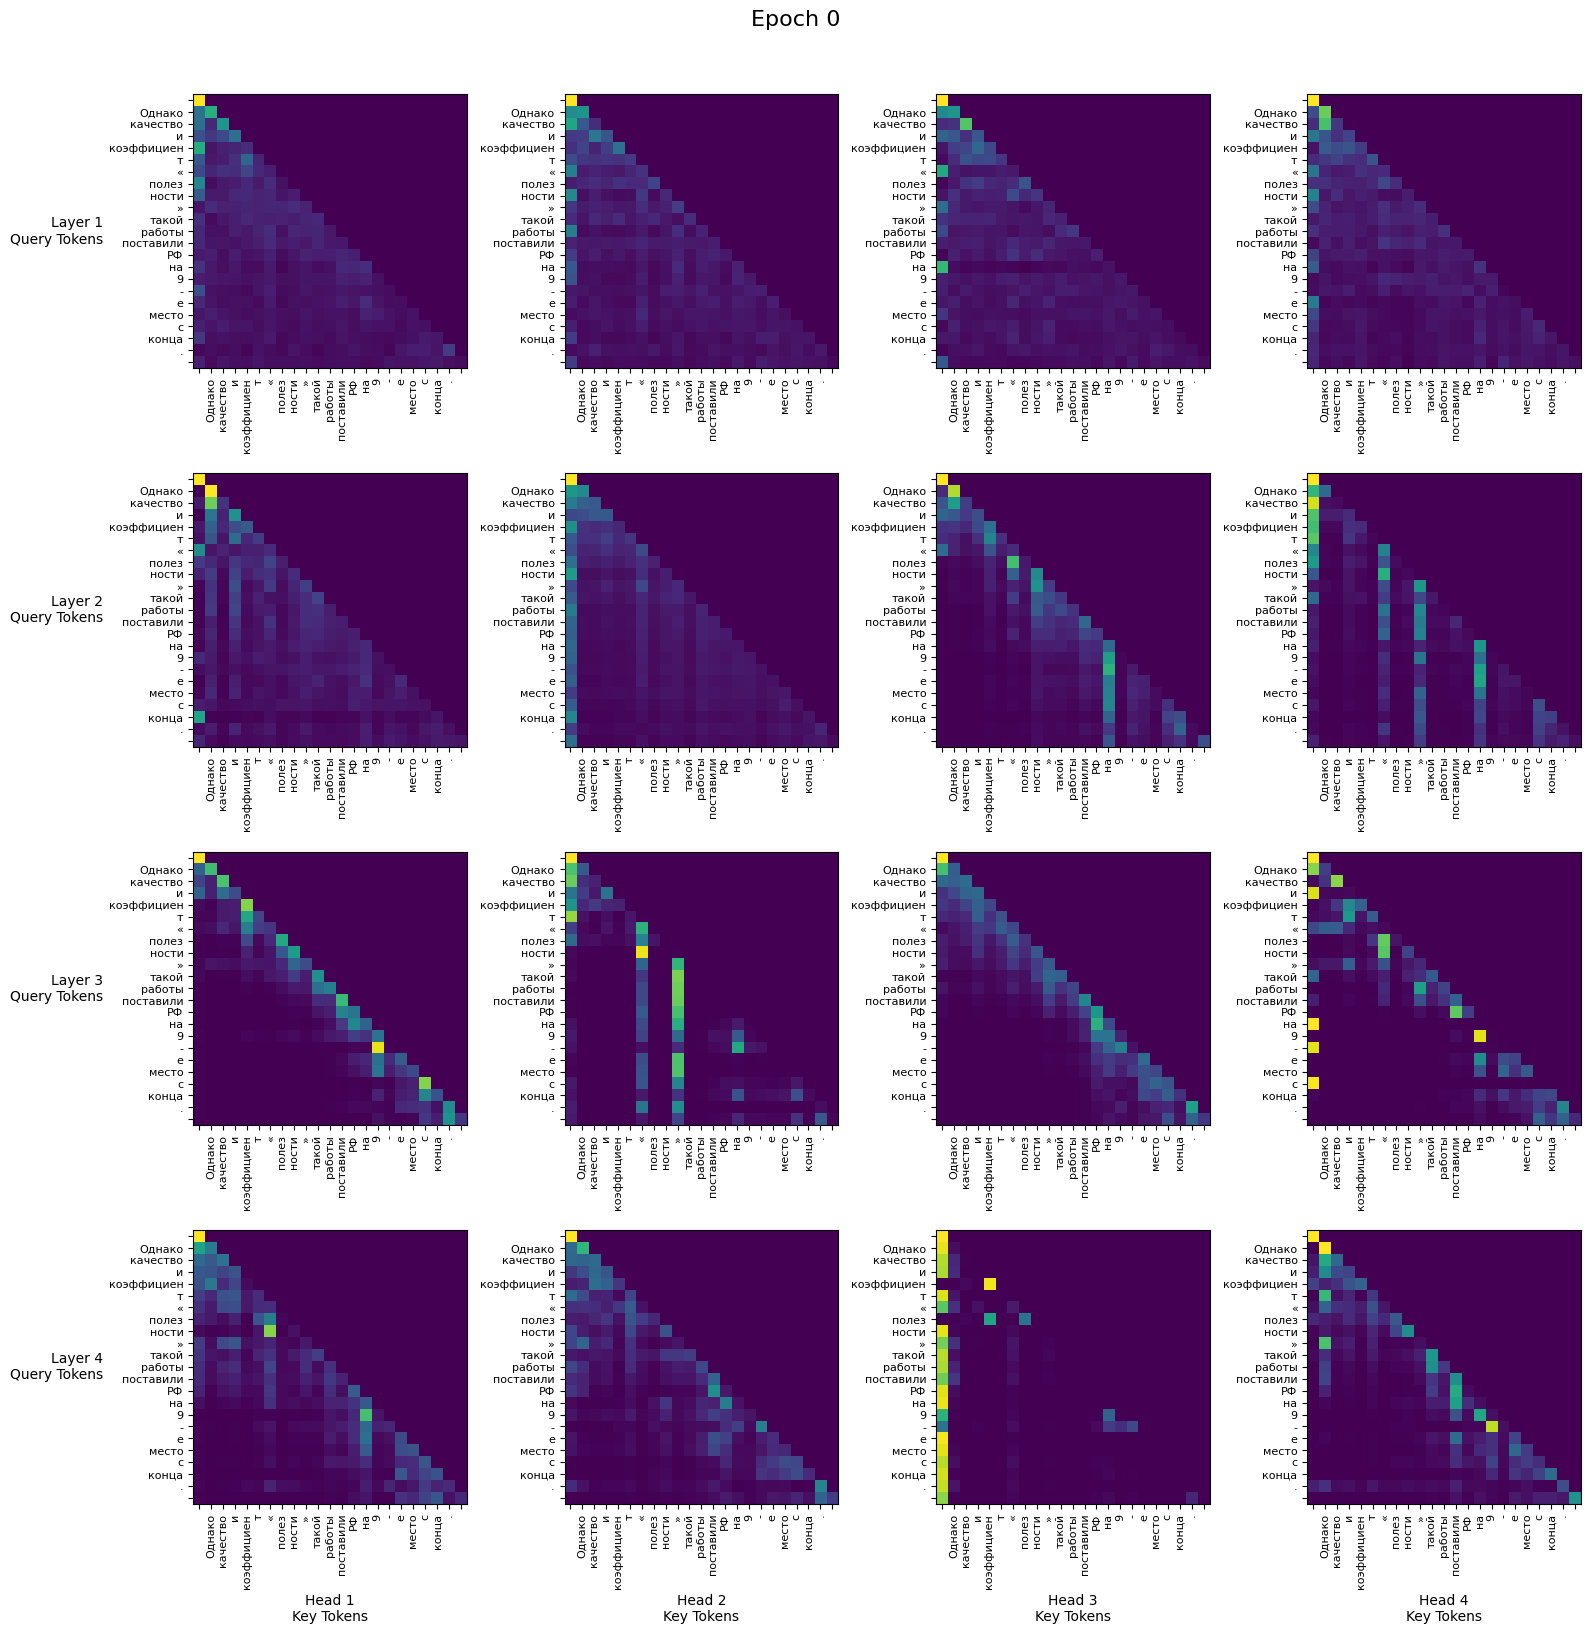

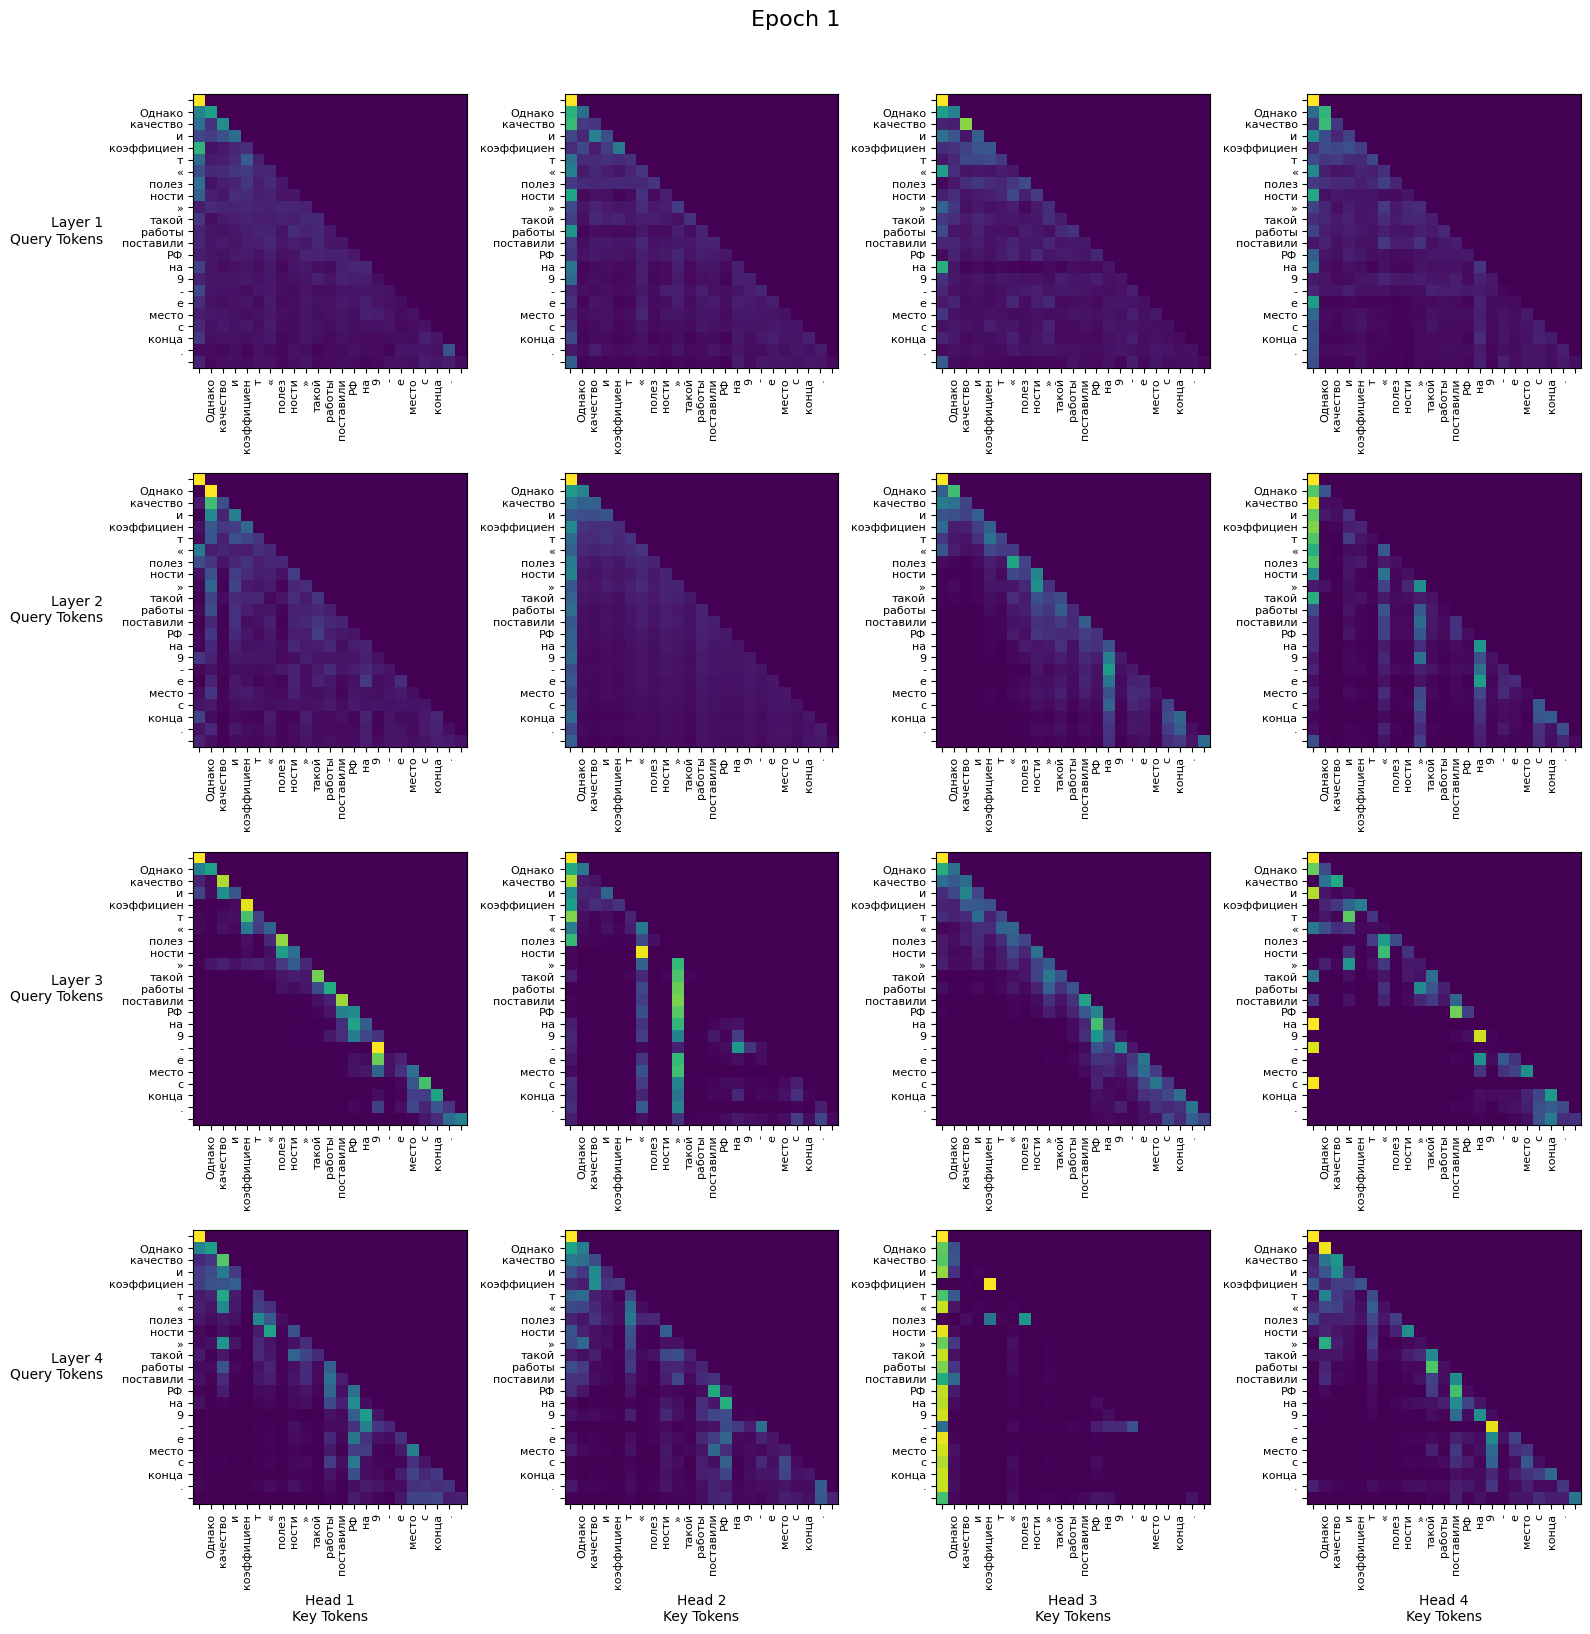

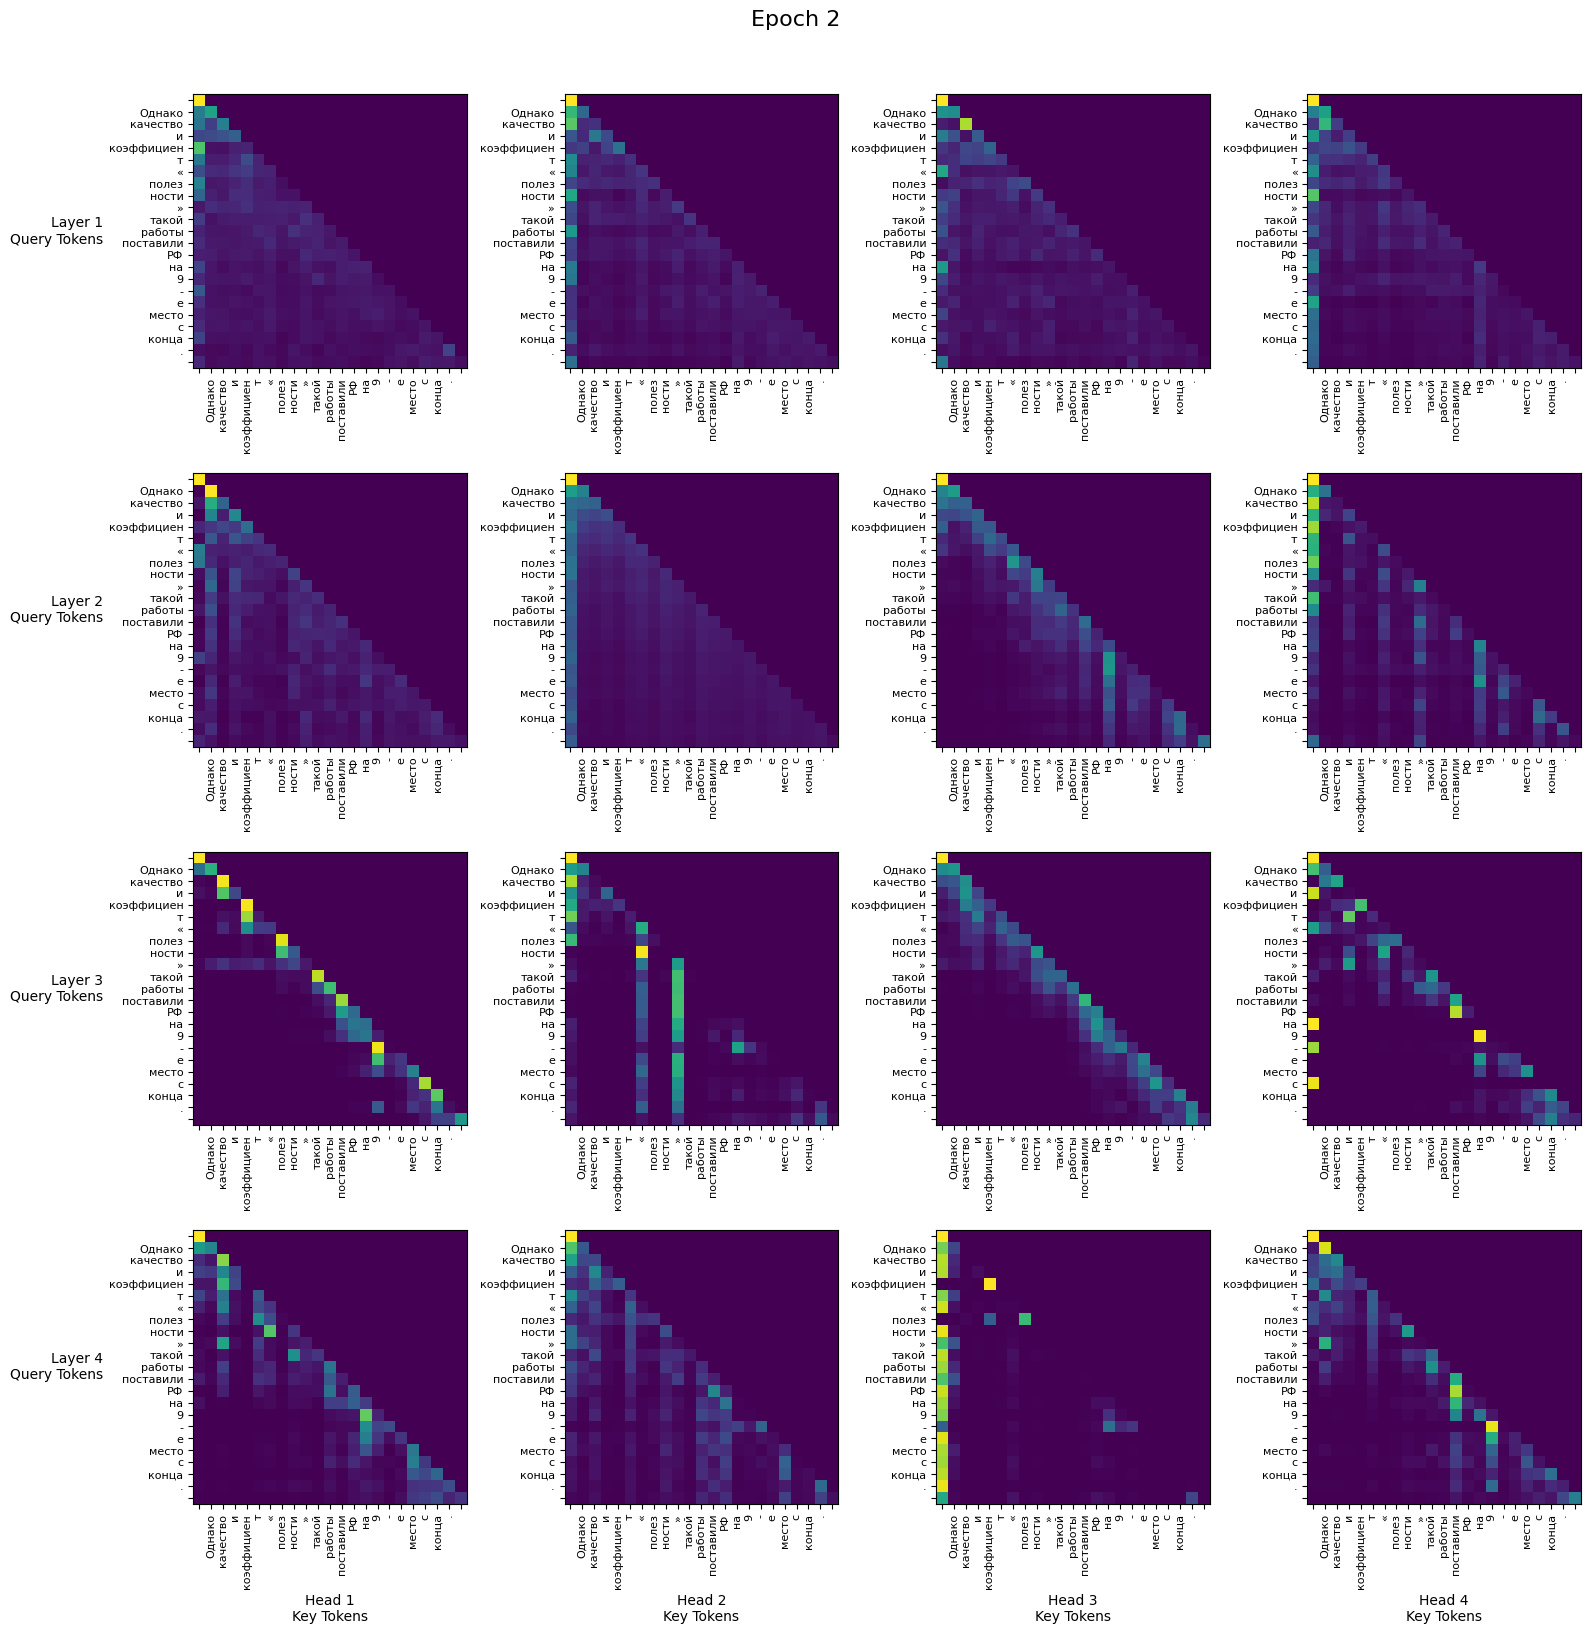

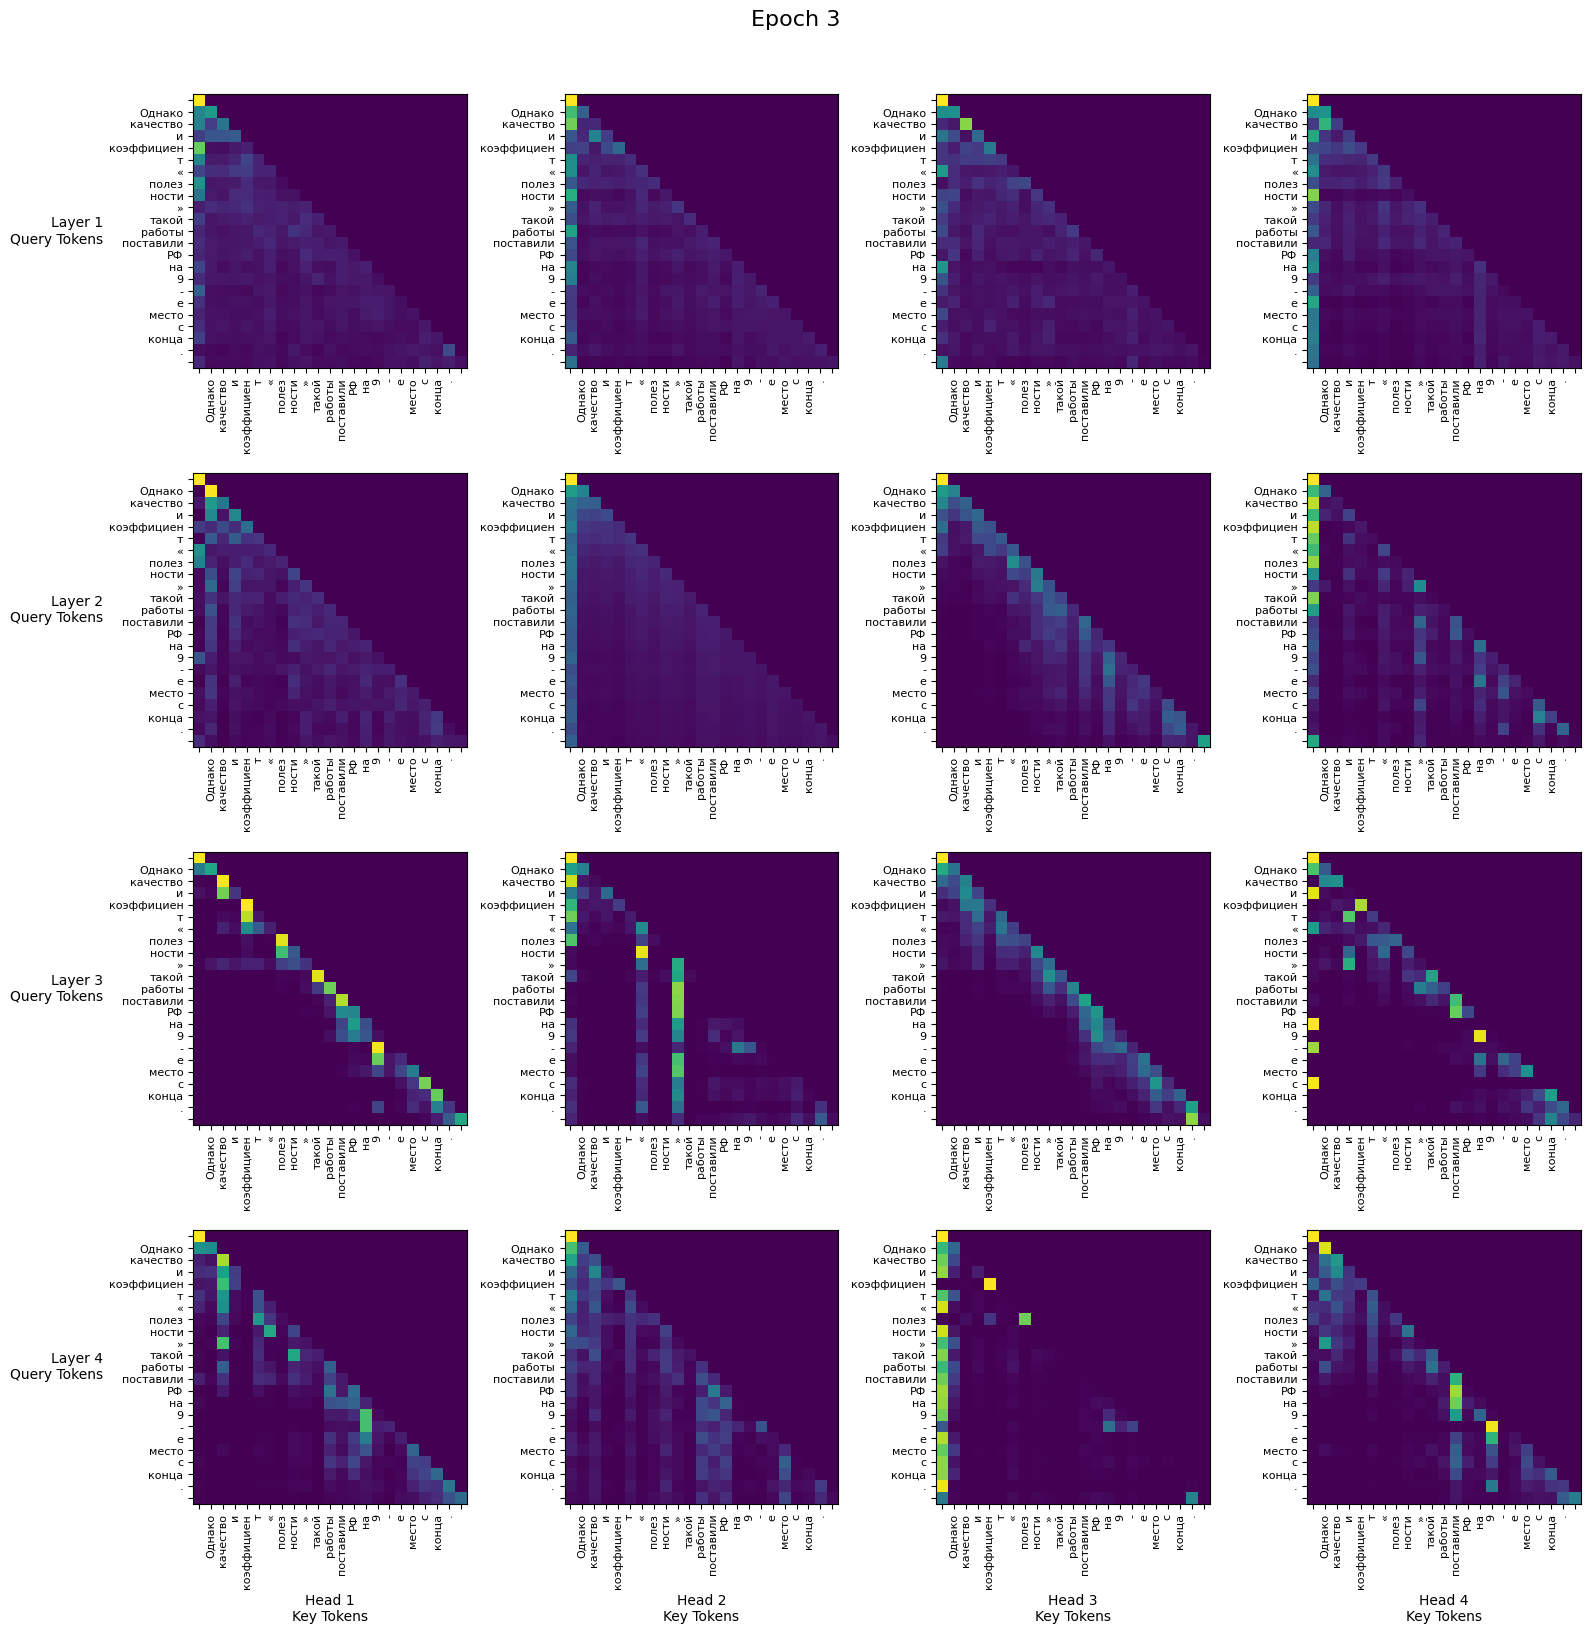

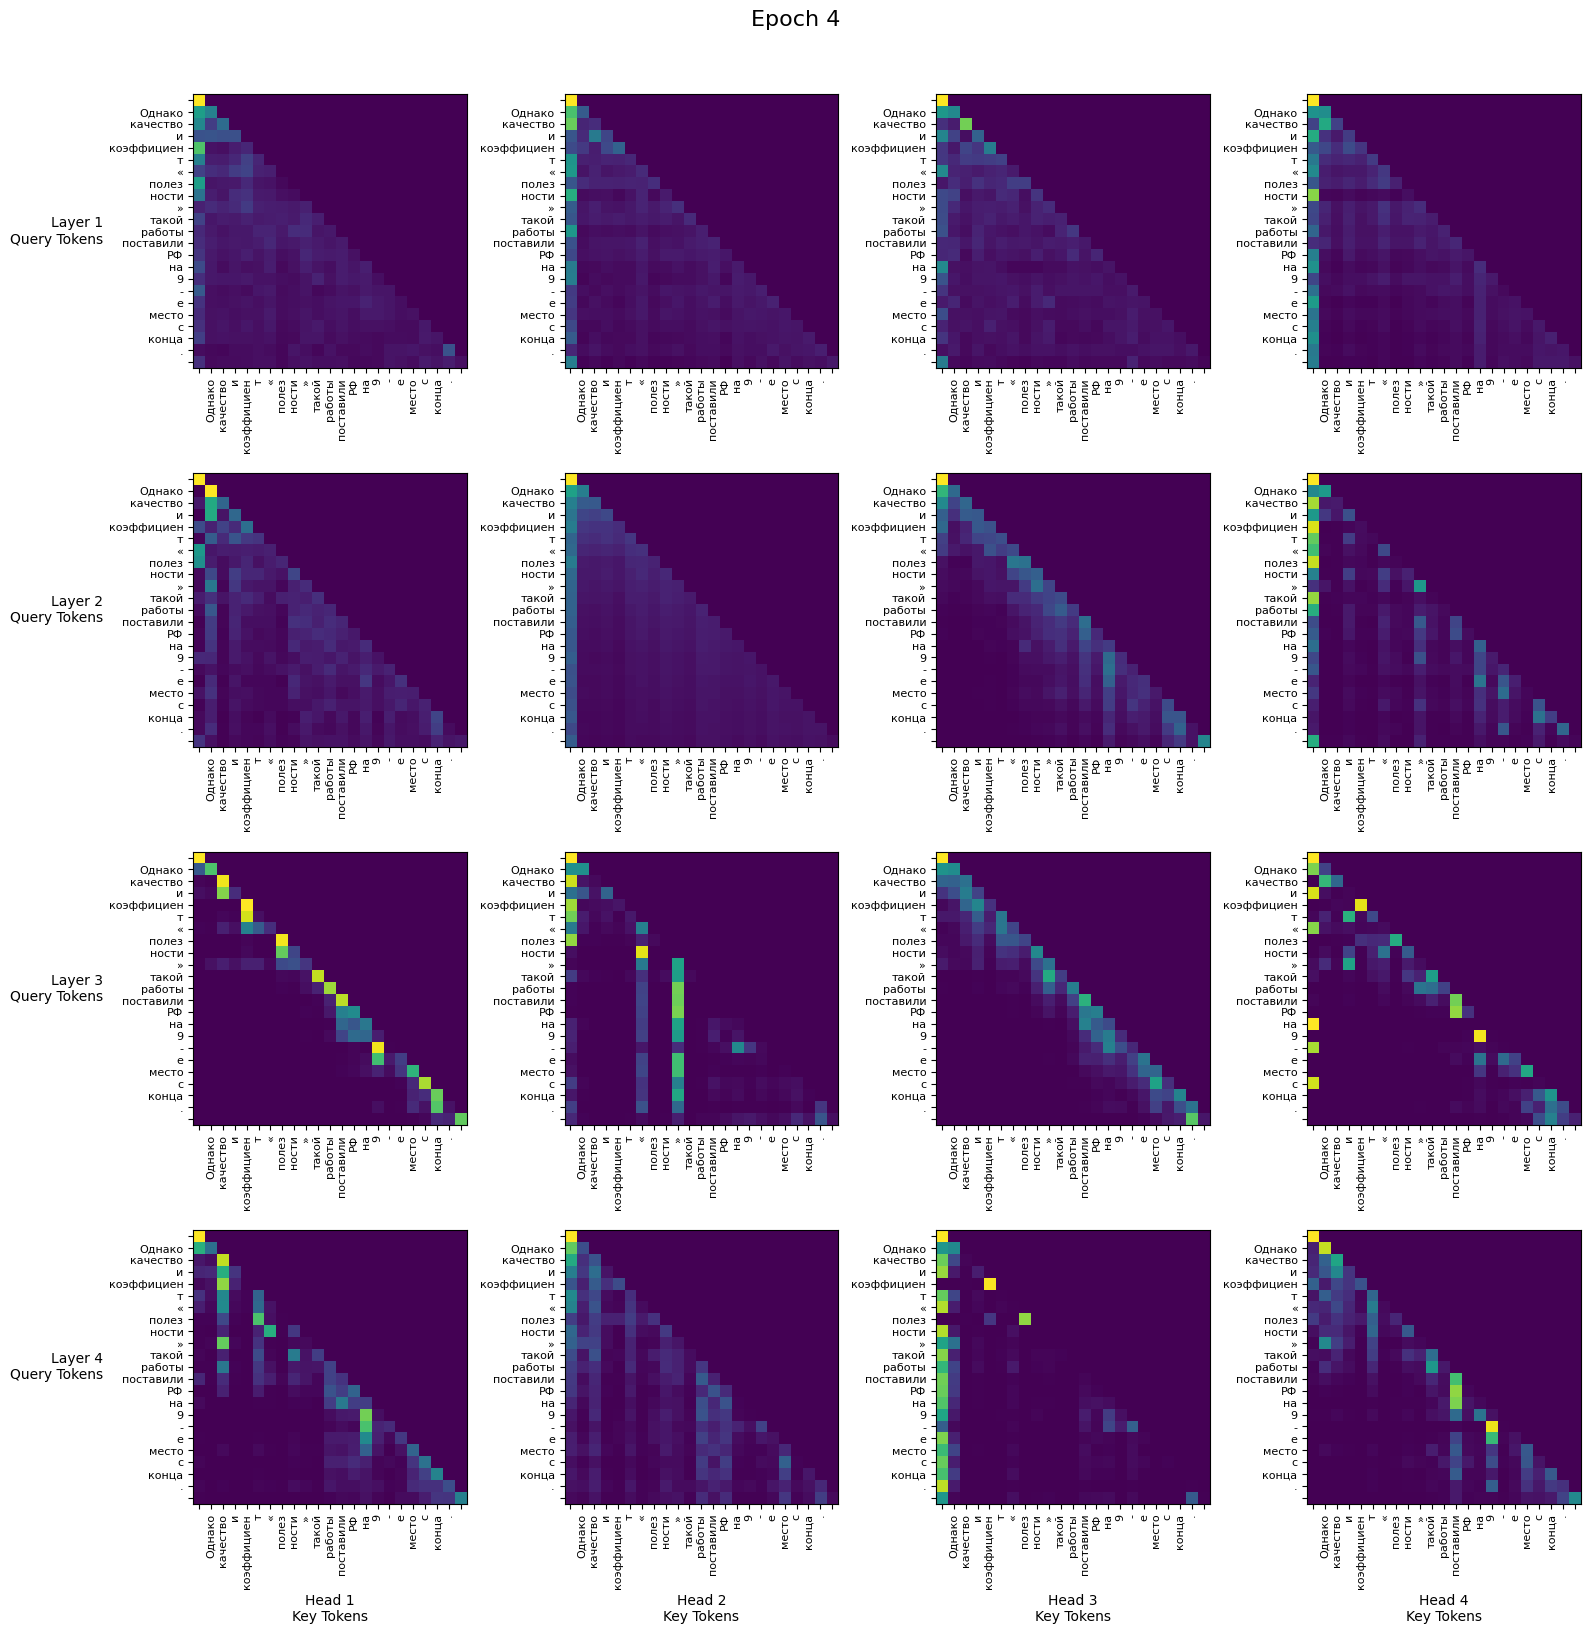

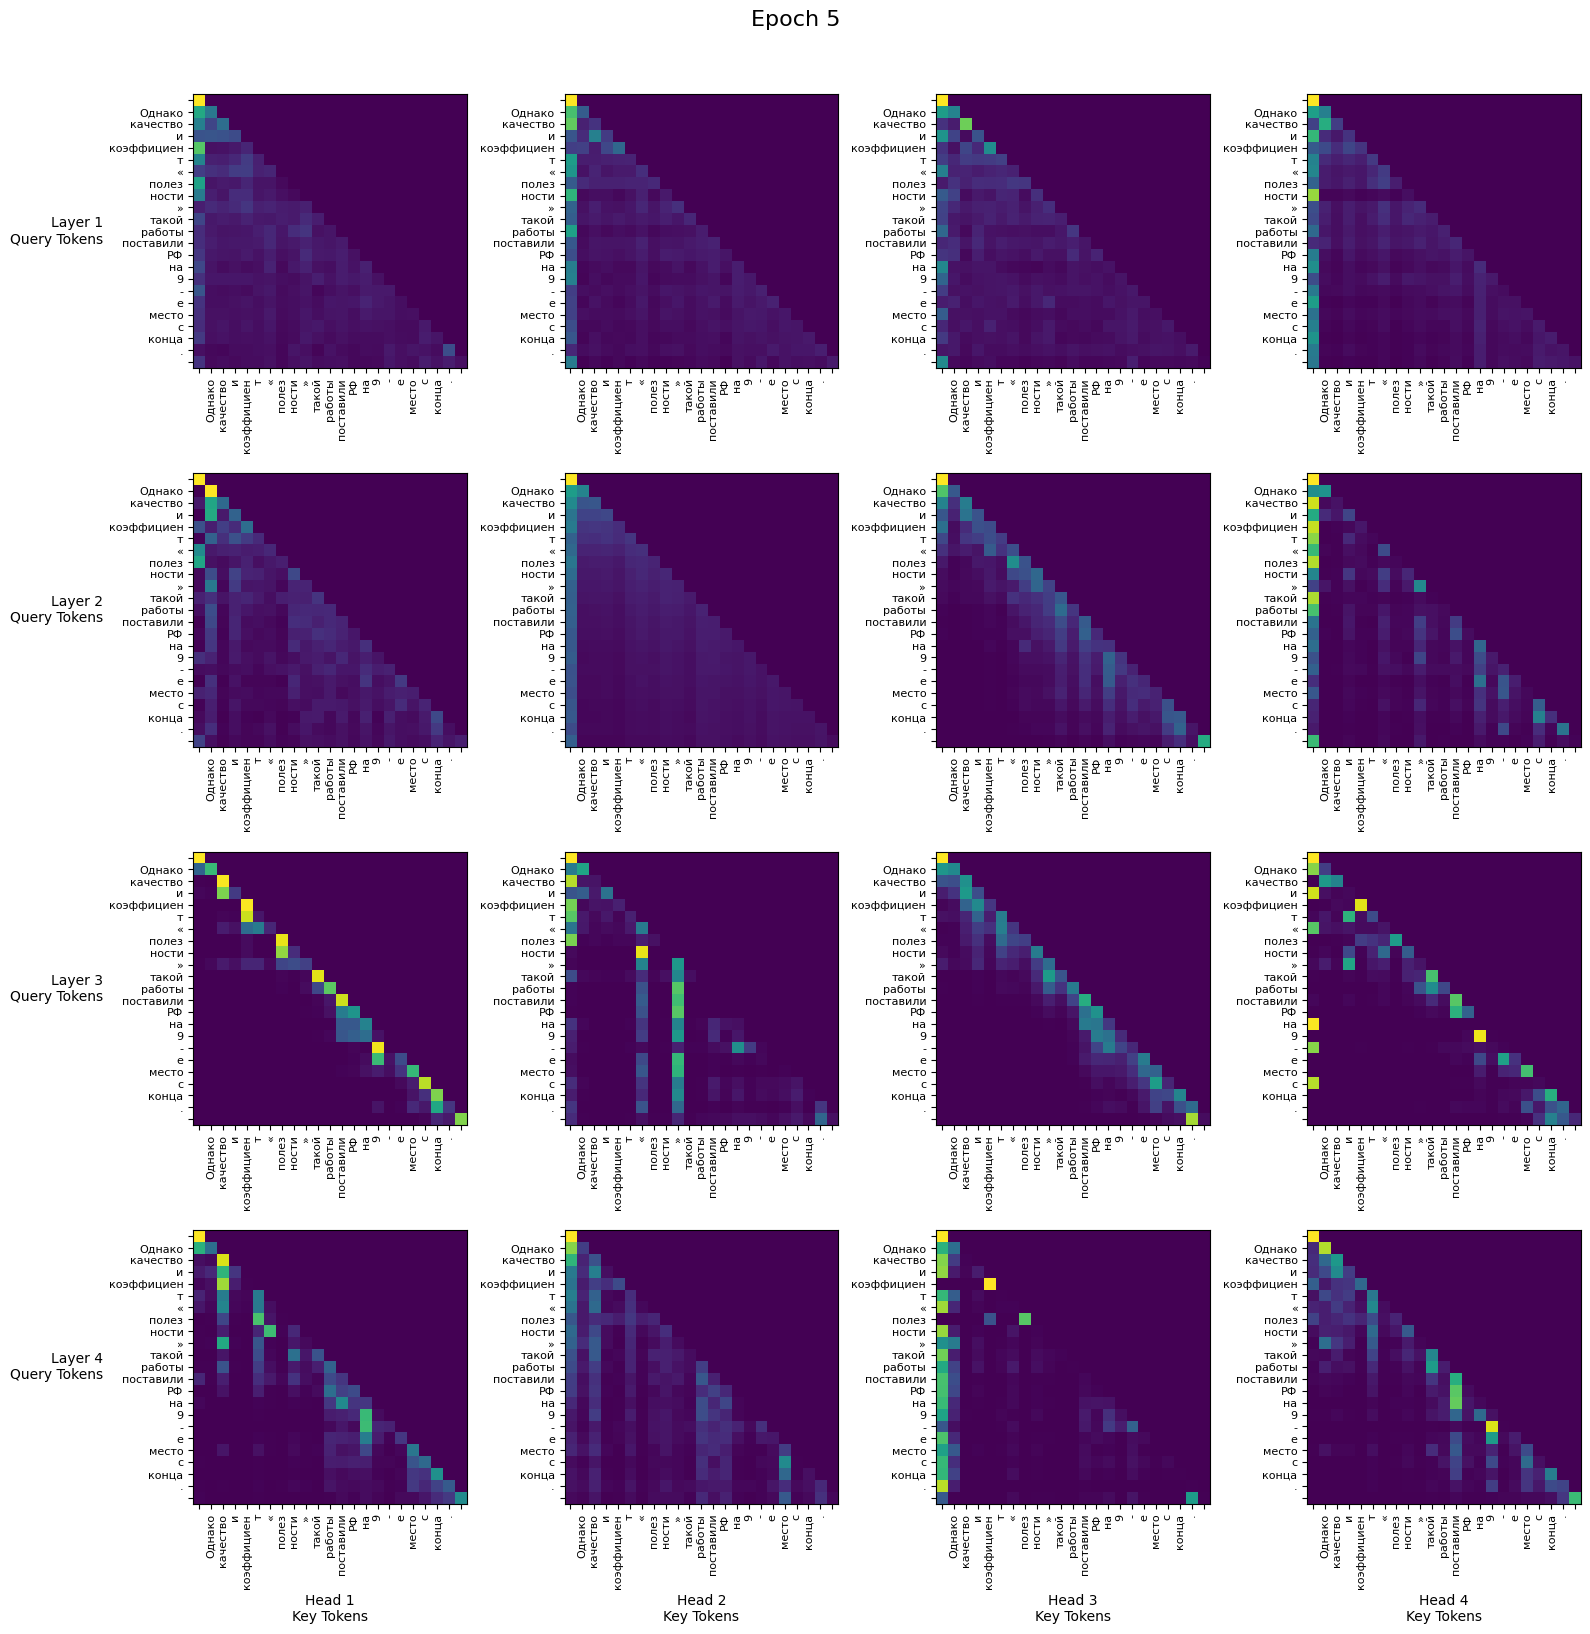

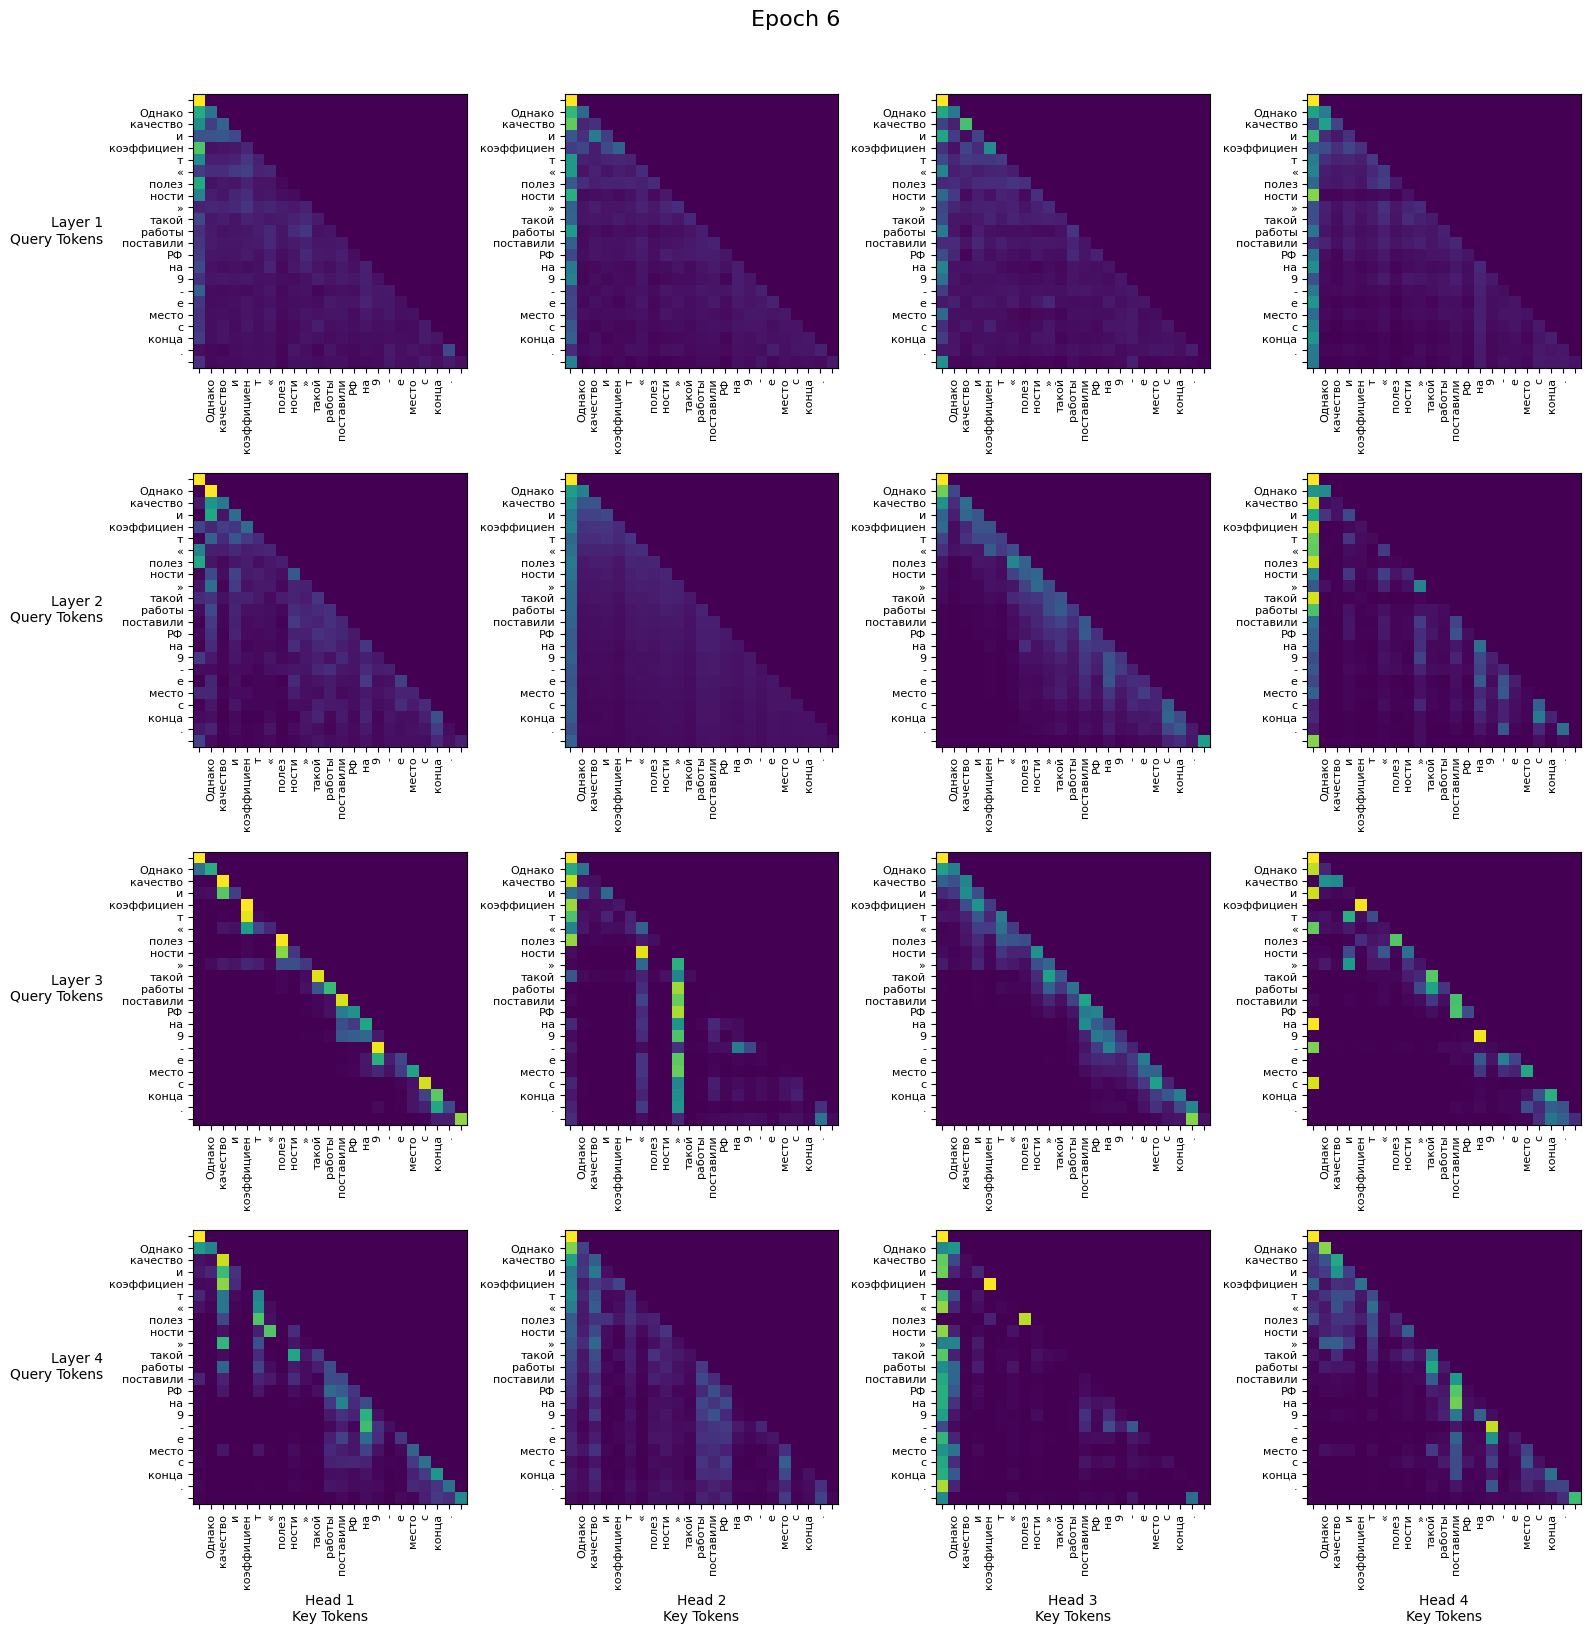

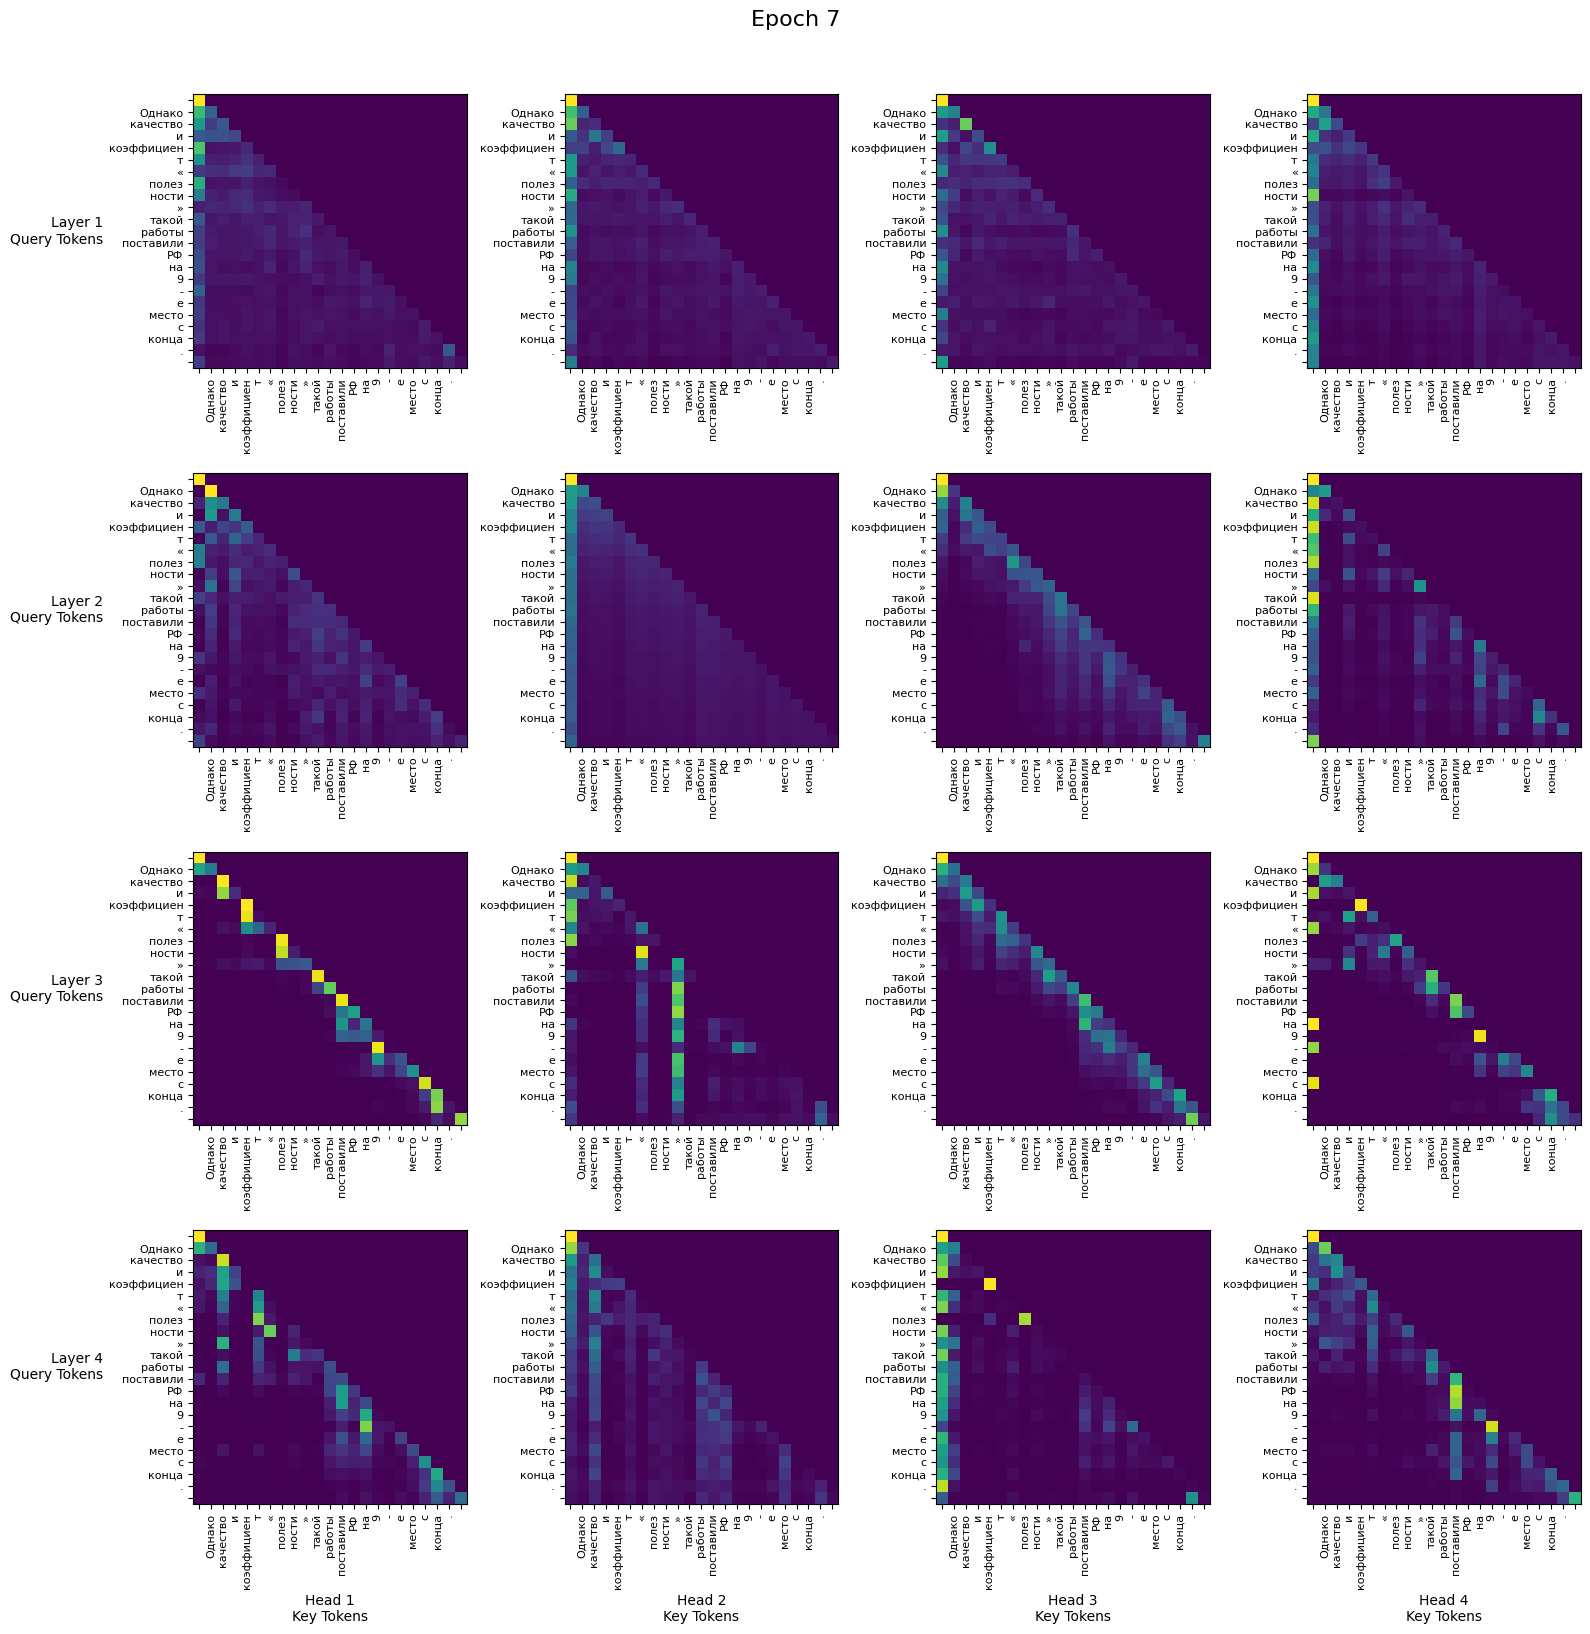

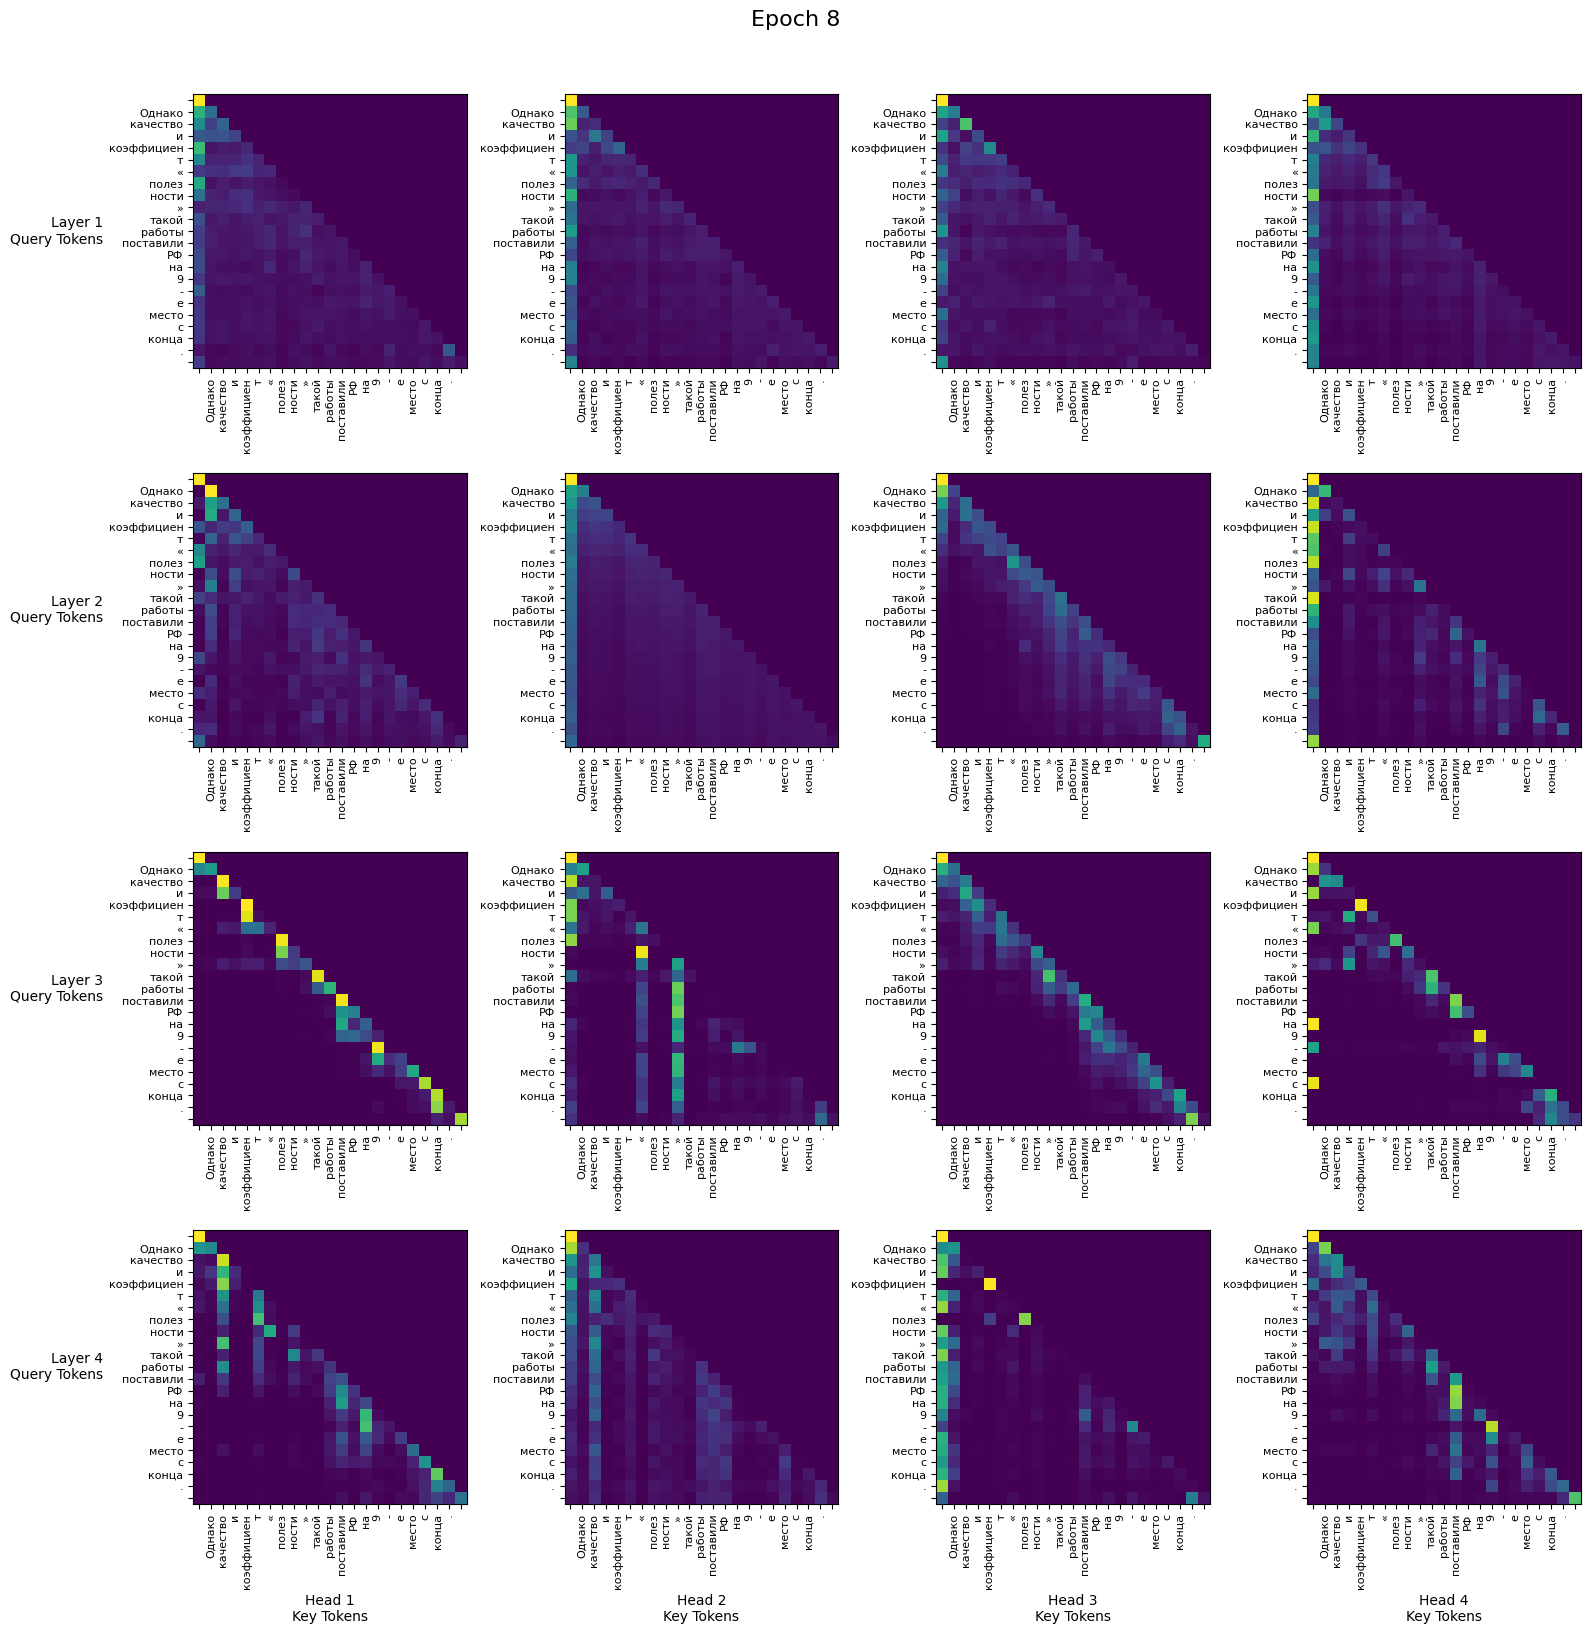

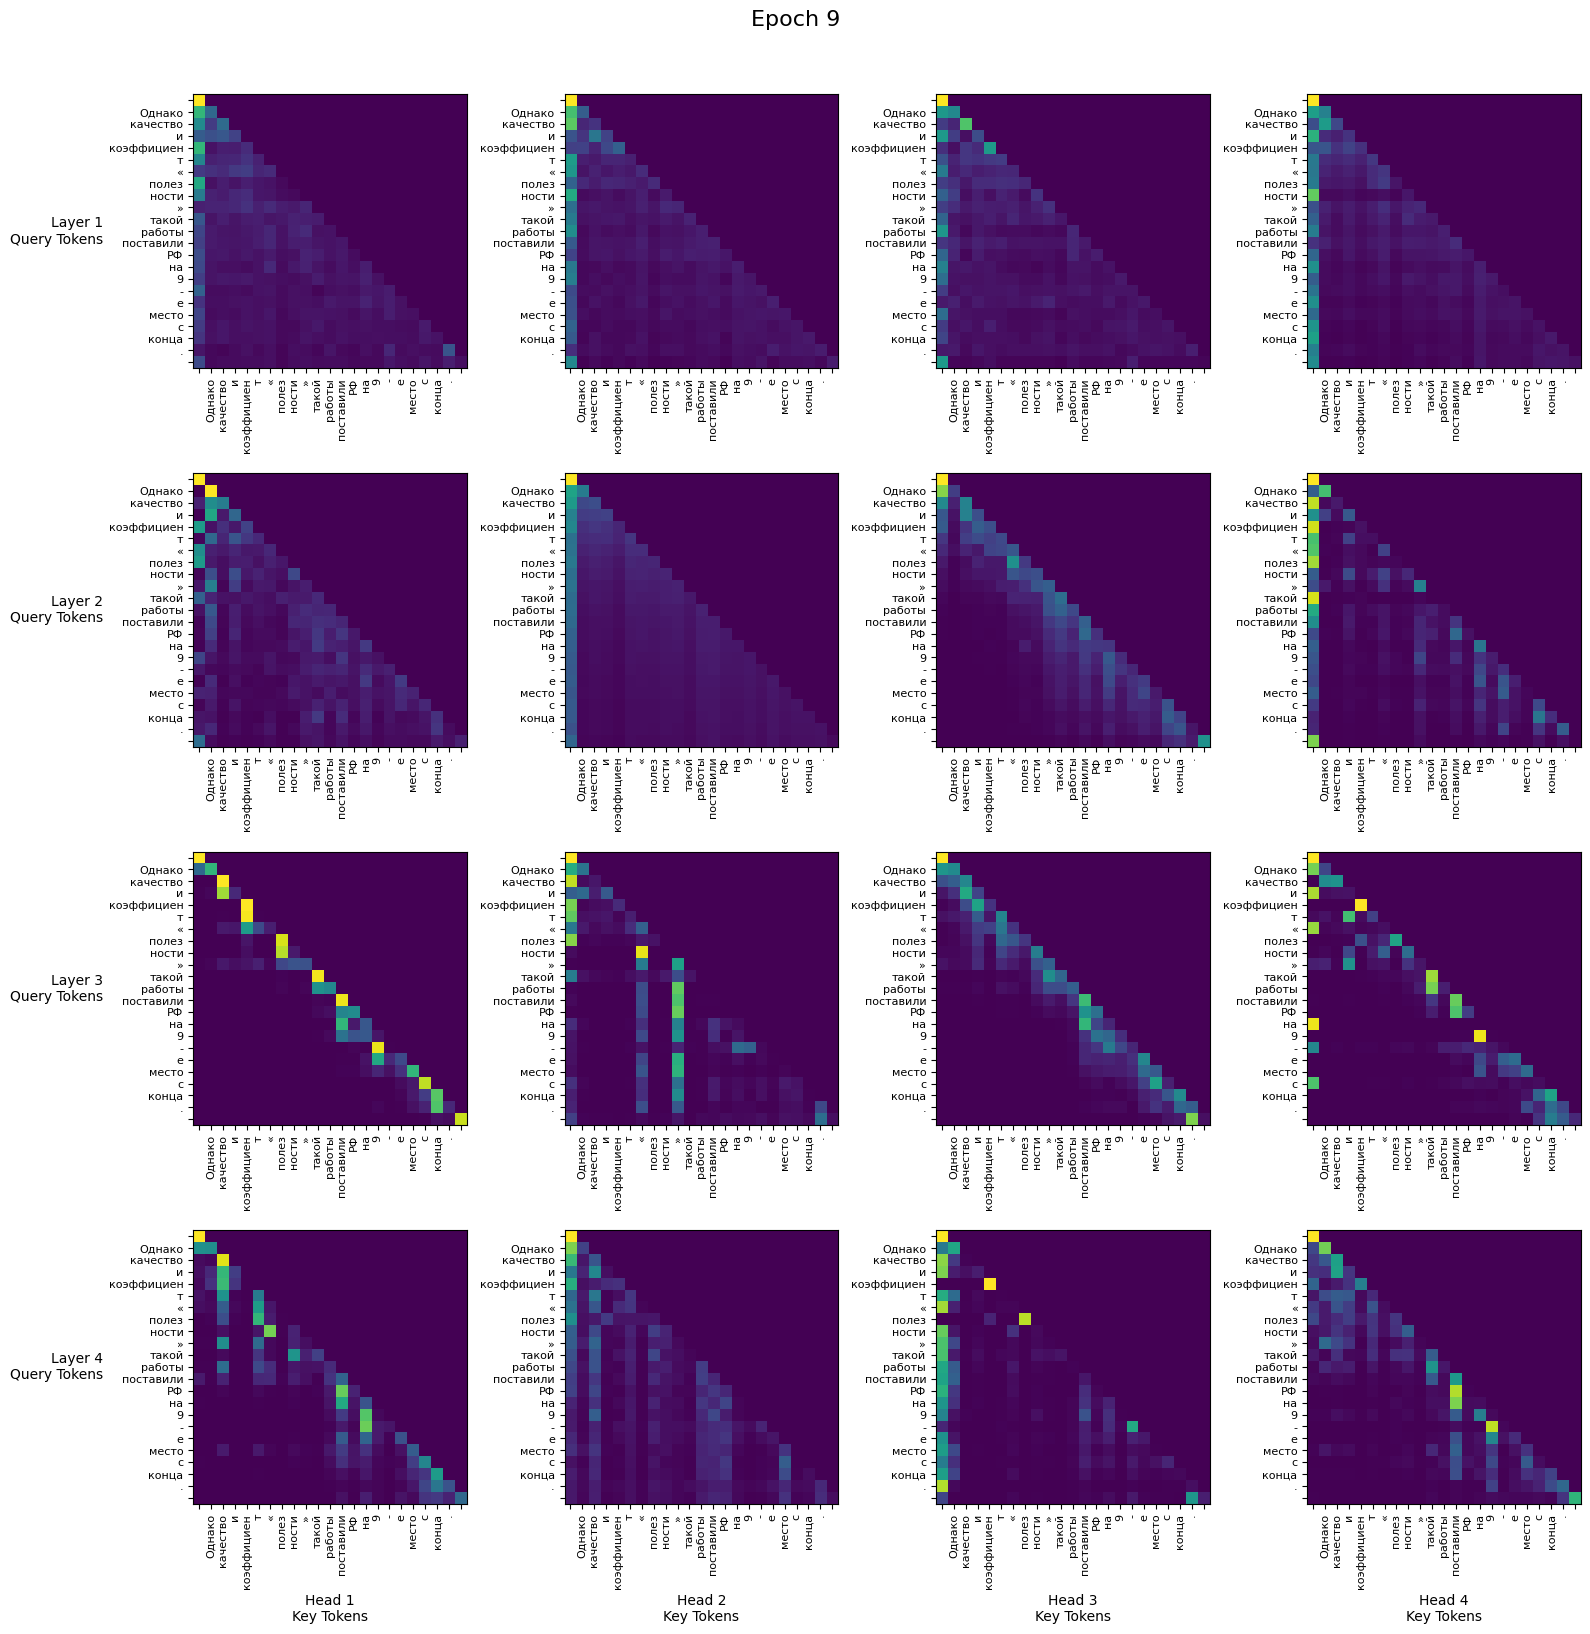

In [17]:
x, y, mask = vis_data
n = mask.sum()
token_labels = []
lst = x[0].tolist()
for i in range(n):
    token_labels.append(tokenizer.decode([lst[i]]))

for epoch, attentions in enumerate(attention_list):
    n_layers = len(attentions)
    n_heads = len(attentions[0]) if n_layers > 0 else 0
    
    fig, axes = plt.subplots(
        n_layers, 
        n_heads, 
        figsize=(4 * n_heads, 4 * n_layers),
        squeeze=False)
    
    fig.suptitle(f"Epoch {epoch}", fontsize=16, y=1.02)
    
    for layer_idx, layer_attentions in enumerate(attentions):
        for head_idx, attention in enumerate(layer_attentions):
            ax = axes[layer_idx, head_idx]
            im = ax.imshow(attention, cmap='viridis')
            if head_idx == 0:
                ax.set_ylabel(f"Layer {layer_idx + 1}\nQuery Tokens", rotation=0, ha='right', va='center')
            if layer_idx == n_layers - 1:
                ax.set_xlabel(f"Head {head_idx + 1}\nKey Tokens")
            ax.set_xticks(range(n))
            ax.set_yticks(range(n))
            ax.set_xticklabels(token_labels, rotation=90, fontsize=8)
            ax.set_yticklabels(token_labels, fontsize=8)

    plt.tight_layout()
    plt.show()
